In [ ]:
# !pip install -q git+https://github.com/Watts-Lab/nomad.git@IC2S2-tutorial

# import gdown
# gdown.cached_download(
#     "https://drive.google.com/uc?id=1wk3nrNsmAiBoTtWznHjjjPkmWAZfxk0P",
#     path="IC2S2_2025.zip",
#     quiet=False,
#     postprocess=gdown.extractall,  # auto-unzip
# )

# **Tutorial 1: Loading and Sampling Trajectory Data**

## Getting started

Real-world mobility files vary widely in structure and formatting:
- e.g. **Timestamps** may be **UNIX** integers or **ISO-formatted strings**
- May have **timezones**, e.g. -05:00, Z, (GMT+01), -3600
- Coordinates might be **projected** or **geographical**
- Files may be a flat **CSV**, or **partitioned Parquets**, local or **in S3**.

`nomad.io` is here to help.

In [1]:
from nomad.io import base as loader

## Inspecting schemas

In [2]:
print(loader.table_columns("gc_data.csv", format="csv"))
print(loader.table_columns("gc_data/", format="csv"))

Index(['identifier', 'device_lon', 'device_lat', 'unix_timestamp',
       'local_datetime', 'date', 'ha'],
      dtype='object')
Index(['user_id', 'longitude', 'latitude', 'timestamp', 'datetime', 'ha',
       'date'],
      dtype='object')


## **Typical processing**. an example with `pandas`, `geopandas`

Perform preliminary analysis of the data in (`gc-data.csv`).
- **Load** trajectory and geometry data.
- **Plot the data of a user** 
- Create **a heatmap** of ping **hotspots**.
- Analyze **gaps** in the user's signals.

In [3]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv("gc_data.csv")
city = gpd.read_file("garden_city.geojson")

df.head()

,identifier,device_lon,device_lat,unix_timestamp,local_datetime,date,ha
0,cocky_stallman,-38.318802,36.669894,1704114435,2024-01-01 09:07:15-04:00,2024-01-01,8.492856
1,cocky_stallman,-38.318765,36.669905,1704114753,2024-01-01 09:12:33-04:00,2024-01-01,11.336772
2,cocky_stallman,-38.318627,36.669856,1704114792,2024-01-01 09:13:12-04:00,2024-01-01,18.436612
3,cocky_stallman,-38.318661,36.669920,1704114989,2024-01-01 09:16:29-04:00,2024-01-01,27.370737
4,cocky_stallman,-38.318602,36.669823,1704115195,2024-01-01 09:19:55-04:00,2024-01-01,12.506606


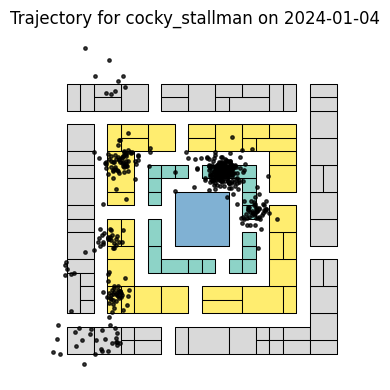

In [4]:
import matplotlib.pyplot as plt

user = df['identifier'].iloc[0]
date = '2024-01-04'

user_df = df.loc[(df['identifier'] == user) & (df['date'] == date)]


fig, ax1 = plt.subplots(figsize=(4,4))
ax1.set_axis_off()

city.plot(ax=ax1, column='type', edgecolor='black', linewidth=0.75, cmap='Set3')
ax1.scatter(user_df['device_lon'], user_df['device_lat'], s=6, alpha=0.75, color='black')
plt.title(f"Trajectory for {user} on {date}")

plt.tight_layout()
plt.show()

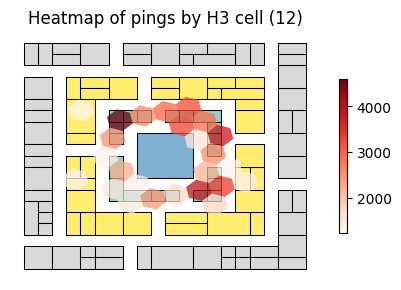

In [5]:
import h3
from shapely import Polygon

# GOTCHA 1: (lat, lon) or (lon, lat)
def h3_cell_to_polygon(cell):
    coords = h3.cell_to_boundary(cell)
    lat, lon = zip(*coords)
    return Polygon(zip(lon, lat))

# Cell for each row
def row_to_h3_cell(row, res):
    return h3.latlng_to_cell(lat=row['device_lat'], lng=row['device_lon'], res=res)

df['cell'] = df.apply(row_to_h3_cell, res=12, axis=1)

pings_per_cell = df.groupby('cell').agg(pings=('unix_timestamp', 'count')).reset_index()
cell_geometries = pings_per_cell['cell'].apply(h3_cell_to_polygon)

h3_gdf = gpd.GeoDataFrame(pings_per_cell, geometry=cell_geometries)
h3_gdf = h3_gdf.loc[h3_gdf.pings>1200] # Try 800

fig, ax2 = plt.subplots(figsize=(5,4))
city.plot(ax=ax2, column='type', edgecolor='black', linewidth=0.75, cmap='Set3') 
h3_gdf.plot(column=h3_gdf.pings, cmap='Reds', alpha=0.75, ax=ax2, legend=True, legend_kwds={'shrink': 0.5}) # try cmap='inferno' or 'plasma'
ax2.set_axis_off()
plt.title("Heatmap of pings by H3 cell (12)")
plt.show()

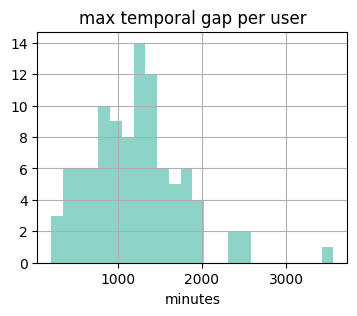

In [6]:
def get_max_gap_minutes(times):
    shifted_times = times.shift(1, fill_value=0) # shift gives previous value
    gaps = (times.iloc[1:] - shifted_times.iloc[1:])//60 # gaps in minutes
    return gaps.max()

max_gap = df.groupby('identifier')['unix_timestamp'].apply(get_max_gap_minutes)

fig, ax3 = plt.subplots(figsize=(4,3))
max_gap.hist(ax=ax3, bins=24, color='#8dd3c7')
ax3.set_xlabel('minutes')
ax3.set_title('max temporal gap per user')
plt.show()

## `nomad.io` — facilitates type casting and default names

`nomad.io.base.from_file` is basically a `pandas` / `pyarrow` wrapper, trying to simplify the formatting of canonical variables

- dates and datetimes in **ISO format** are cast to `pandas.datetime64`
- **unix timestamps** are cast to integers and **reformatted to seconds**.
- **user identifiers** are cast to strings
- **partition folders** can be read as columns (Hive)

In [7]:
from nomad.constants import DEFAULT_SCHEMA
print("Canonical column names in nomad")
DEFAULT_SCHEMA

Canonical column names in nomad


{'user_id': 'user_id',
 'latitude': 'latitude',
 'longitude': 'longitude',
 'datetime': 'datetime',
 'start_datetime': 'start_datetime',
 'end_datetime': 'end_datetime',
 'start_timestamp': 'start_timestamp',
 'end_timestamp': 'end_timestamp',
 'timestamp': 'timestamp',
 'date': 'date',
 'utc_date': 'date',
 'x': 'x',
 'y': 'y',
 'geohash': 'geohash',
 'tz_offset': 'tz_offset',
 'duration': 'duration',
 'ha': 'ha',
 'h3_cell': 'h3_cell',
 'location_id': 'location_id'}

Don't read partitioned data with a for loop! `nomad`'s `from_file` wraps `PyArrow`'s file readers maintaning the same signature. 

In [11]:
## SKIP THIS CELL ##

# For the single csv dataset
traj_cols = {"user_id": "identifier",
             "timestamp": "unix_timestamp",
             "latitude": "device_lat",
             "longitude": "device_lon",
             "datetime": "local_datetime",
             "date": "date"}
file_path = "gc_data.csv"

df = loader.from_file(file_path, format="csv", traj_cols=traj_cols)
# check data types
print(df.dtypes)

identifier                object
device_lon               float64
device_lat               float64
unix_timestamp             Int64
local_datetime    datetime64[ns]
date                      object
ha                       float64
tz_offset                  Int64
dtype: object


In [8]:
# For the partitioned dataset
traj_cols = {"user_id": "user_id",
             "timestamp": "timestamp",
             "latitude": "latitude",
             "longitude": "longitude",
             "datetime": "datetime",
             "date": "date"}

file_path = "gc_data/" # partitioned


df = loader.from_file(file_path, format="csv", traj_cols=traj_cols, parse_dates=True)
print(df.dtypes)

user_id              object
longitude           float64
latitude            float64
timestamp             Int64
datetime     datetime64[ns]
ha                  float64
date                 object
tz_offset             Int64
dtype: object


In [12]:
## Compute all three statistics as before
from nomad.filters import to_tessellation

user_df = loader.sample_from_file(
    file_path, format="csv", users=["cocky_stallman"],
    filters=("date", "==", "2024-01-04"), traj_cols=traj_cols) # filter on read

# Pings per cell geodataframe 
df["cell"] = to_tessellation(df, index="h3", res=12, traj_cols=traj_cols)

pings_per_cell = df.groupby('cell').agg(pings=(traj_cols['timestamp'], 'count')).reset_index()
h3_gdf = gpd.GeoDataFrame(pings_per_cell, geometry=pings_per_cell['cell'].apply(h3_cell_to_polygon))
h3_gdf = h3_gdf.loc[h3_gdf.pings>1000]

# Maximum gap for each user
max_gap = df.groupby(traj_cols['user_id'])[traj_cols['timestamp']].apply(get_max_gap_minutes)

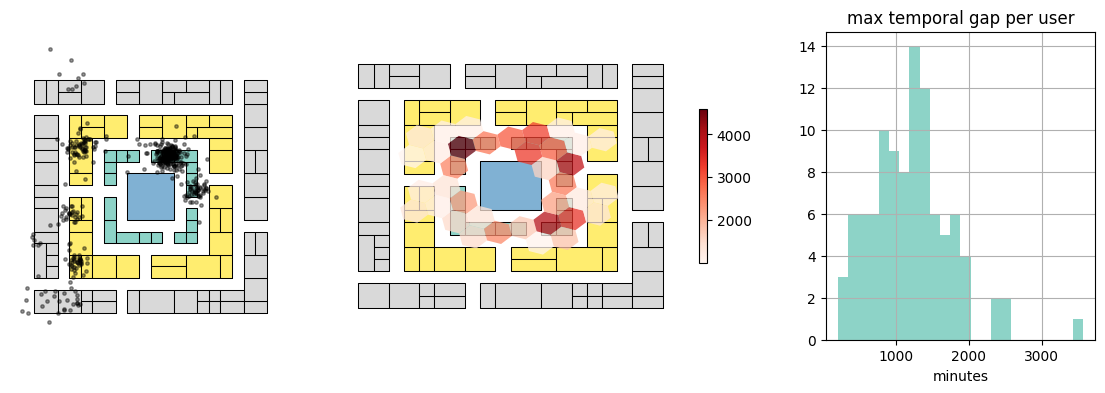

In [13]:
from nomad.stop_detection.viz import plot_pings
## Plotting
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3, width_ratios=[4.5, 7, 4.5])

# trajectory of a single user
city.plot(ax=ax1, column='type', edgecolor='black', linewidth=0.75, cmap='Set3')
plot_pings(user_df, ax=ax1, point_color='black', radius='ha', s=6, alpha=0.4, traj_cols=traj_cols)
ax1.set_axis_off()
# heatmap
city.plot(ax=ax2, column='type', edgecolor='black', linewidth=0.75, cmap='Set3')
h3_gdf.plot(column=h3_gdf.pings, cmap='Reds', alpha=0.75, ax=ax2, legend=True, legend_kwds={'shrink': 0.5})
ax2.set_axis_off()
# gaps
max_gap.hist(ax=ax3, bins=24, color='#8dd3c7')
ax3.set_xlabel('minutes')
ax3.set_title('max temporal gap per user')

plt.show()

Now, go back to (hidden) [cell 7](#hidden-cell) and try simply changing the file path and column name mapping (traj_cols). The rest of the code works the same. 

## Prototype on a small sample of users/records

In [14]:
file_path = "gc_data/" # has default names
fmt = "csv"

# full data
df = loader.from_file(file_path, format=fmt)

# sample users
users = loader.sample_users(file_path, format=fmt, size=12, seed=314) # change if user_id has other name
print(users)
# sample data, pass users
sample_df = loader.sample_from_file(file_path, users=users, format=fmt, frac_records=0.30, seed=314)

## Sample users directly
#sample_df = loader.sample_from_file(file_path, format=fmt, frac_records=0.30, frac_users=0.12, seed=314)

83          upbeat_boyd
24       competent_cori
92       goofy_shockley
95         lucid_bartik
13         pensive_saha
52         happy_panini
23          brave_euler
15            sad_hugle
12    optimistic_agnesi
20    youthful_meninsky
25        dazzling_bose
64       youthful_mayer
dtype: object


In [15]:
loader.to_file(sample_df, "/tmp/nomad_sample2/", format=fmt, partition_by=["date"], existing_data_behavior='overwrite_or_ignore')
data_sample = loader.from_file("/tmp/nomad_sample2/", format=fmt)

C:\Users\pacob\Documents\repositories\nomad-repo\nomad\io\base.py:563: UserWarning: The 'datetime' column has timezone-naive records consider localizing or using unix timestamps.
  warnings.warn(f"The '{col}' column has timezone-naive records consider localizing or using unix timestamps.")


In [16]:
print("- Value counts for sample of data:\n")
print(data_sample.user_id.value_counts())
print("\n---------------------------------\n")
print("- Value counts for original data:\n")
print(df.user_id.value_counts())

- Value counts for sample of data:

user_id
dazzling_bose        851
sad_hugle            846
youthful_mayer       822
lucid_bartik         761
competent_cori       512
happy_panini         488
goofy_shockley       326
pensive_saha         223
optimistic_agnesi    168
brave_euler          164
youthful_meninsky    137
upbeat_boyd           89
Name: count, dtype: int64

---------------------------------

- Value counts for original data:

user_id
vigilant_mendeleev        6015
optimistic_curran         5881
cocky_stallman            3722
practical_jepsen          3488
adoring_khorana           2949
                          ... 
friendly_blackwell         310
nifty_almeida              291
gallant_jones              290
inspiring_visvesvaraya     289
determined_allen           221
Name: count, Length: 100, dtype: int64
